In [2]:
!pip install pyshp

     |████████████████████████████████| 225kB 4.7MB/s eta 0:00:01
  Created wheel for pyshp: filename=pyshp-2.1.0-cp37-none-any.whl size=32609 sha256=67d24e6e7ed38fcfb6922f0b75772982dfc4f4d20df4d33f5410acfd530c7d50
  Stored in directory: /home/angelrps/.cache/pip/wheels/a6/0c/de/321b5192ad416b328975a2f0385f72c64db4656501eba7cc1a
Successfully built pyshp


In [39]:
!pip install geopandas
!pip install descartes

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import random
pd.options.display.max_columns = None
pd.options.display.max_rows = None

import geopandas as gpd
import seaborn as sns
sns.set(style='whitegrid', palette='pastel', color_codes=True)
sns.mpl.rc('figure', figsize=(10,6))

In [12]:
# opening the vector map
shp_path = "../z_resources/data_test/taxi_zones/taxi_zones.shp"
assert os.path.exists(shp_path), "Input file does not exist."

# set the filepath and load
shapefile = "../z_resources/data_test/taxi_zones/taxi_zones.shp"
# reading the shape file, importing just 4 columns
map_df = gpd.read_file(shapefile)[['zone', 'LocationID', 'borough', 'geometry']]

# filter Manhattan zones
map_df = map_df[map_df['borough'] == 'Manhattan']

# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
print(type(map_df))
map_df.head(70)

<class 'geopandas.geodataframe.GeoDataFrame'>


,zone,LocationID,borough,geometry
3,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
11,Battery Park,12,Manhattan,"POLYGON ((979908.772 196066.565, 979980.852 19..."
12,Battery Park City,13,Manhattan,"POLYGON ((980801.310 201248.869, 980697.386 20..."
23,Bloomingdale,24,Manhattan,"POLYGON ((995453.114 230274.267, 995312.583 23..."
40,Central Harlem,41,Manhattan,"POLYGON ((998716.913 234240.397, 999458.736 23..."
41,Central Harlem North,42,Manhattan,"POLYGON ((1002413.191 243934.560, 1002388.021 ..."
42,Central Park,43,Manhattan,"POLYGON ((991852.973 217950.807, 991725.244 21..."
44,Chinatown,45,Manhattan,"POLYGON ((984941.821 199431.157, 984958.446 19..."
47,Clinton East,48,Manhattan,"POLYGON ((986694.313 214463.846, 986568.184 21..."
49,Clinton West,50,Manhattan,"POLYGON ((985170.372 221087.389, 985817.170 22..."


In [3]:
# filter Manhattan zones
map_df2 = map_df[map_df['borough'] == 'Manhattan']

# remove duplicated zone 103 (Liberty Island)
map_df2.drop([102,103], inplace=True)

map_df2.head(70)

/home/angelrps/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
11,12,0.036661,0.000042,Battery Park,12,Manhattan,"POLYGON ((979908.772 196066.565, 979980.852 19..."
12,13,0.050281,0.000149,Battery Park City,13,Manhattan,"POLYGON ((980801.310 201248.869, 980697.386 20..."
23,24,0.047000,0.000061,Bloomingdale,24,Manhattan,"POLYGON ((995453.114 230274.267, 995312.583 23..."
40,41,0.052793,0.000143,Central Harlem,41,Manhattan,"POLYGON ((998716.913 234240.397, 999458.736 23..."
41,42,0.092709,0.000264,Central Harlem North,42,Manhattan,"POLYGON ((1002413.191 243934.560, 1002388.021 ..."
42,43,0.099739,0.000380,Central Park,43,Manhattan,"POLYGON ((991852.973 217950.807, 991725.244 21..."
44,45,0.045907,0.000091,Chinatown,45,Manhattan,"POLYGON ((984941.821 199431.157, 984958.446 19..."
47,48,0.043747,0.000094,Clinton East,48,Manhattan,"POLYGON ((986694.313 214463.846, 986568.184 21..."
49,50,0.055748,0.000173,Clinton West,50,Manhattan,"POLYGON ((985170.372 221087.389, 985817.170 22..."


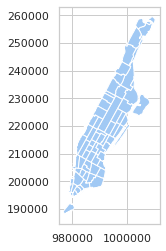

In [4]:
map_df2.plot()

In [5]:
data = pd.DataFrame({'RandVariable':np.random.randn(67)})

map_df2.reset_index(inplace=True, drop=True)
data.reset_index(inplace=True, drop=True)
print(map_df2.shape, data.shape)
display(map_df2.head(2), data.head(2))
map_df2 = map_df2.join(data)
map_df2.head()

(67, 7) (67, 1)


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
1,12,0.036661,0.000042,Battery Park,12,Manhattan,"POLYGON ((979908.772 196066.565, 979980.852 19..."


,RandVariable
0,-0.633609
1,-0.060280


,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry,RandVariable
0,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20...",-0.633609
1,12,0.036661,0.000042,Battery Park,12,Manhattan,"POLYGON ((979908.772 196066.565, 979980.852 19...",-0.060280
2,13,0.050281,0.000149,Battery Park City,13,Manhattan,"POLYGON ((980801.310 201248.869, 980697.386 20...",0.761702
3,24,0.047000,0.000061,Bloomingdale,24,Manhattan,"POLYGON ((995453.114 230274.267, 995312.583 23...",0.854531
4,41,0.052793,0.000143,Central Harlem,41,Manhattan,"POLYGON ((998716.913 234240.397, 999458.736 23...",-0.261394


/home/angelrps/anaconda3/lib/python3.7/site-packages/matplotlib/colors.py:109: FutureWarning: `item` has been deprecated and will be removed in a future version
  ret = ex.item()


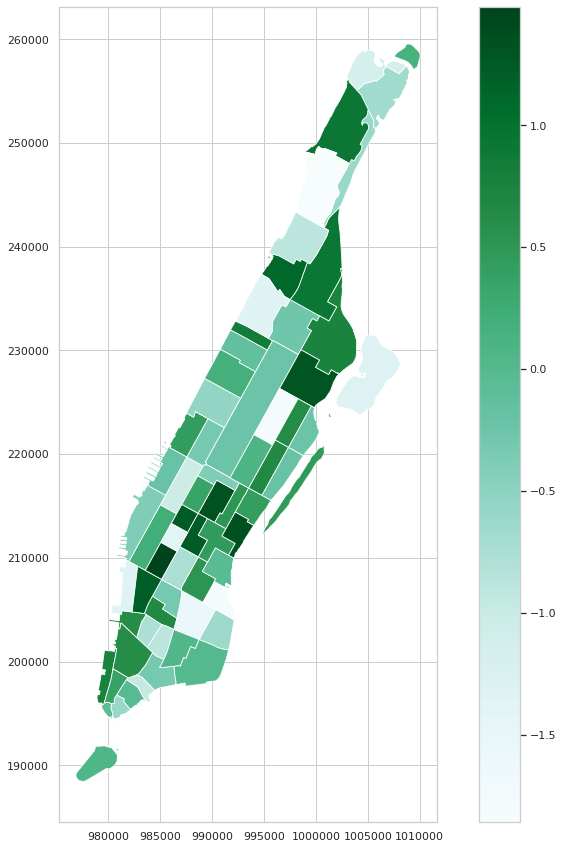

In [10]:
# set the range for the choropleth
vmin, vmax = data.min(), data.max()# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(15, 15))

map_df2.plot(column='RandVariable', cmap='BuGn', linewidth=0.8, ax=ax, edgecolor='1')

# Create colorbar as a legend
colorBar = plt.cm.ScalarMappable(cmap='BuGn', norm=plt.Normalize(vmin=vmin, vmax=vmax))

# add the colorbar to the figure
cbar = fig.colorbar(colorBar)

### Incorporate Bokeh library to introduce interactivity
Bokeh consumes GeoJSON format so I´ll convert the GeoDataFrame to GeoJSON

In [17]:
import json

#Read data to json.
map_df2_json = json.loads(map_df2.to_json())

# convert to String like  object
map_df2_json_data = json.dumps(map_df2_json)

#### Function to get x and y coordinates from the geometry polygon

In [57]:
map_df2['geometry'][11][1].exterior.coords.xy[1]

array('d', [231053.29040525854, 230986.47951865196, 230967.44901885092, 231016.5014038235, 231025.93438720703, 231032.53759767115, 230978.76879882812, 230984.4285888821, 231053.29040525854])

In [41]:
def getPolyCoords(row, geom, coord_type):
    """Returns the coordinates ('x' or 'y') of edges of a Polygon exterior"""
    polygonList = []
    
    for row in row[geom]:
        if row.type == 'MultiPolygon':
            for polygone in row.geoms:
            polygoneList.append(polygone)
        else:
            polygoneList.append(row)
    # Parse the exterior of the coordinate
    exterior = row[geom].exterior

    if coord_type == 'x':
        # Get the x coordinates of the exterior
        return list( exterior.coords.xy[0] )
    elif coord_type == 'y':
        # Get the y coordinates of the exterior
        return list( exterior.coords.xy[1] )

In [42]:
map_df2['x'] = map_df2.apply(getPolyCoords, geom='geometry', coord_type='x', axis=1)
map_df2['y'] = map_df2.apply(getPolyCoords, geom='geometry', coord_type='y', axis=1)
map_df2.head()

AttributeError: ("'MultiPolygon' object has no attribute 'exterior'", 'occurred at index 11')

### Render choropeth map using Bokeh

In [82]:
from bokeh.io import output_notebook, show, output_file
from bokeh.plotting import figure
from bokeh.models import GeoJSONDataSource, LinearColorMapper, ColorBar
from bokeh.palettes import brewer
import json

#Read data to json.
map_df2_json = json.loads(map_df2.to_json())

# convert to String like  object
map_df2_json_data = json.dumps(map_df2_json)

# 1. Create GeoJSONDataSource
geosource = GeoJSONDataSource(geojson = map_df2_json_data)

# 2. define colour palette
# https://colorbrewer2.org/#type=sequential&scheme=BuGn&n=3
# [10] number of colour in the palette
palette = brewer['OrRd'][8]

# 2.1 reverse number of colours so the dark colour represents the higher value
palette = palette[::-1]

# 2.2. Instantiate LinearColorMapper that linearly maps numbers in a range into a sequence of colors.
color_mapper = LinearColorMapper(palette = palette, low = float(data.min()), high = float(data.max()))

# Create colour bar
color_bar = ColorBar(color_mapper = color_mapper,
                     label_standoff = 8,
                     width = 500, height = 20,
                     border_line_color = None,
                     location = (0,0),
                    orientation = 'horizontal')

# Create figure object
f = figure(title = 'Taxi Demand in Manhattan',
          plot_height = 600, plot_width = 950, toolbar_location = None)
f.xgrid.grid_line_color = None
f.ygrid.grid_line_color = None

# Add patch renderer to the figure
#fill_color = {'field':'RendVariable', 'transform':color_mapper}
f.patches('xs','ys', source = geosource,
          fill_color = None,
         line_color = 'black',
         line_width = '0.25')

# specify figure layout
f.add_layout(color_bar, 'below')

#output_notebook()
show(f)

In [77]:
f.multi_polygons

<bound method multipolygons of Figure(id='2466', ...)>